In [1]:
import os
from os import path
import pkg_resources
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import logging

from adopt_pytorch.models import ADOPT, train_binary_model
from adopt_pytorch.data import MILData
from adopt_pytorch.feature_ranking import (disturb_parameters, compute_features_precursor_scores,
                                           rank_features, identify_start_end_threshold)
from adopt_pytorch.visualization import plot_precursor_scores

print(pkg_resources.get_distribution('adopt_pytorch').version)
nominal_flights_dir = "./data/nominal_events"
adverse_flight_dir = "./data/adverse_events"

logger = logging.getLogger('Data')
logger.setLevel(logging.INFO)

c:\Users\bleul\miniconda3\envs\adopt\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.1.0


In [22]:
DF_Nominal = []
count = 0
for i, a_file in enumerate(os.listdir(nominal_flights_dir)):
    temp = pd.read_csv(path.join(nominal_flights_dir, a_file))
    temp['flight_id'] = count
    temp.loc[:, 'Label'] = temp['Label'].max()
    # temp = temp.iloc[:-np.random.randint(0, 30),:]
    DF_Nominal.append(temp)
    count += 1
DF_Nominal = pd.concat(DF_Nominal)

DF_Adverse = []
for i, a_file in enumerate(os.listdir(adverse_flight_dir), i + 1):
    temp = pd.read_csv(path.join(adverse_flight_dir, a_file))
    temp['flight_id'] = count
    temp.loc[:, 'Label'] = temp['Label'].max()
    # if count == 399:
    #     temp = temp.iloc[:-5,:]
    # temp = temp.iloc[:-np.random.randint(0, 30),:]
    DF_Adverse.append(temp)
    count += 1
DF_Adverse = pd.concat(DF_Adverse)

In [24]:
DF = pd.concat([DF_Nominal, DF_Adverse])
DF.head()

,Param1,Param2,Param3,Param4,Param5,Param6,Param7,Param8,Param9,Param10,Label,flight_id
0,0.054420,0.886721,2.208355,3.008612,3.779844,4.817153,5.980221,7.362841,7.884413,8.948450,0.0,0
1,-0.084038,0.937670,2.005556,3.068711,3.944730,5.069581,6.016285,6.879754,7.986532,9.000271,0.0,0
2,-0.111761,0.909595,2.038305,3.076019,3.884544,5.051107,6.067016,7.057355,7.955401,9.046895,0.0,0
3,-0.124806,0.876025,1.994516,3.044928,3.868345,5.094251,6.152597,6.998116,8.014256,9.108317,0.0,0
4,-0.118633,0.795664,1.968469,3.100817,3.845539,5.049403,6.182839,7.056712,8.040389,9.144961,0.0,0


In [25]:
DF.tail()

,Param1,Param2,Param3,Param4,Param5,Param6,Param7,Param8,Param9,Param10,Label,flight_id
95,-0.091456,0.641713,2.281341,2.998968,4.171046,4.318966,5.498181,7.288236,8.016408,9.068619,1.0,399
96,-0.108380,0.687833,2.290933,2.946179,4.098033,4.321263,5.528805,7.233765,8.044389,9.013097,1.0,399
97,-0.079386,0.695453,2.314574,2.900783,4.055215,4.365232,5.553016,7.314535,8.100825,9.018535,1.0,399
98,-0.102022,0.707356,2.289830,2.932854,4.057353,4.464618,5.637918,7.319968,8.160996,8.994099,1.0,399
99,-0.097604,0.621495,2.429622,2.898894,4.113182,4.382730,5.610593,7.355191,8.179479,9.000796,1.0,399


In [27]:
data = MILData(DF, drop_time_col=False)
data.MIL_processing(anonamly_column='Label', pad_value='mean', different_length_method='list')

INFO:Data:There are: 400, 200 nominal and 200 adverse


In [28]:
if not data.data_is_scaled:
    data.normalize_data(avoid_columns=['Label', 'flight_id'])
    print('here')

here


In [29]:
adopt = ADOPT(data.scaled_x_train[0].shape[-1] if isinstance(data.scaled_x_train, list) else data.scaled_x_train.shape[-1],
              data.parameters_list,
              device='cuda:0')

In [30]:
 clf, hist, val_hist, (b_acc, val_b_acc, f1, val_f1) = train_binary_model(adopt, data.scaled_x_train,
                                          data.trainY, batch_size=10, 
                                          print_every_epochs=10, n_epochs=30,
                                          l2=0.01, 
                                          learning_rate=0.01,
                                          verbose=0, ignore_warnings=True)

INFO:models:Mini-batch strategy: Stratified
  0%|          | 0/30 [00:00<?, ?it/s]INFO:models:Proportion Class 0.0: 0.5
INFO:models:Proportion Class 1.0: 0.5
100%|██████████| 30/30 [00:06<00:00,  4.45it/s]


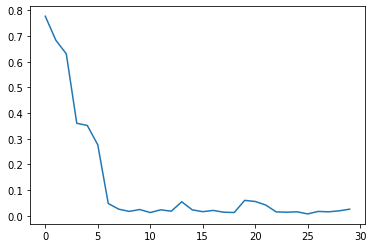

In [31]:
plt.plot(hist)

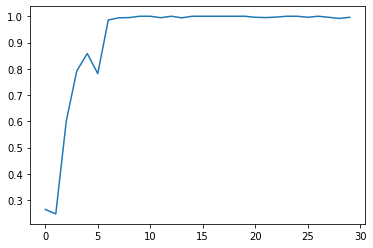

In [32]:
plt.plot(f1)

In [33]:
# Get flight id 43 (randomly chosen)
idx = 43

In [34]:
# Verify True Positive
print(data.testY[idx])
print(clf(data.scaled_x_test[idx, :, :].reshape(1,
                                        data.scaled_x_test.shape[1],
                                        data.scaled_x_test.shape[2]),
          False))

[1.]
tensor([0.8895], grad_fn=<ViewBackward0>)


In [36]:
# Get flight id for this idx
flight_id = data.retrieve_flight_id_using_flight_idx(idx, data_set='test')
flight_id

284

In [37]:
precursor_score_list = disturb_parameters(clf, data.scaled_x_test[idx, :, :].reshape(1,
                                                                                    data.scaled_x_test.shape[1],
                                                                                    data.scaled_x_test.shape[2]),
                                          param_index_dict= data.param_index_dict,
                                          list_parameters=data.parameters_list[:-2], )

INFO:feature_ranking:Case: upper. Computing pertubation for Param1
INFO:feature_ranking:Case: lower. Computing pertubation for Param1
INFO:feature_ranking:Case: upper. Computing pertubation for Param2
INFO:feature_ranking:Case: lower. Computing pertubation for Param2
INFO:feature_ranking:Case: upper. Computing pertubation for Param3
INFO:feature_ranking:Case: lower. Computing pertubation for Param3
INFO:feature_ranking:Case: upper. Computing pertubation for Param4
INFO:feature_ranking:Case: lower. Computing pertubation for Param4
INFO:feature_ranking:Case: upper. Computing pertubation for Param5
INFO:feature_ranking:Case: lower. Computing pertubation for Param5
INFO:feature_ranking:Case: upper. Computing pertubation for Param6
INFO:feature_ranking:Case: lower. Computing pertubation for Param6
INFO:feature_ranking:Case: upper. Computing pertubation for Param7
INFO:feature_ranking:Case: lower. Computing pertubation for Param7
INFO:feature_ranking:Case: upper. Computing pertubation for Pa

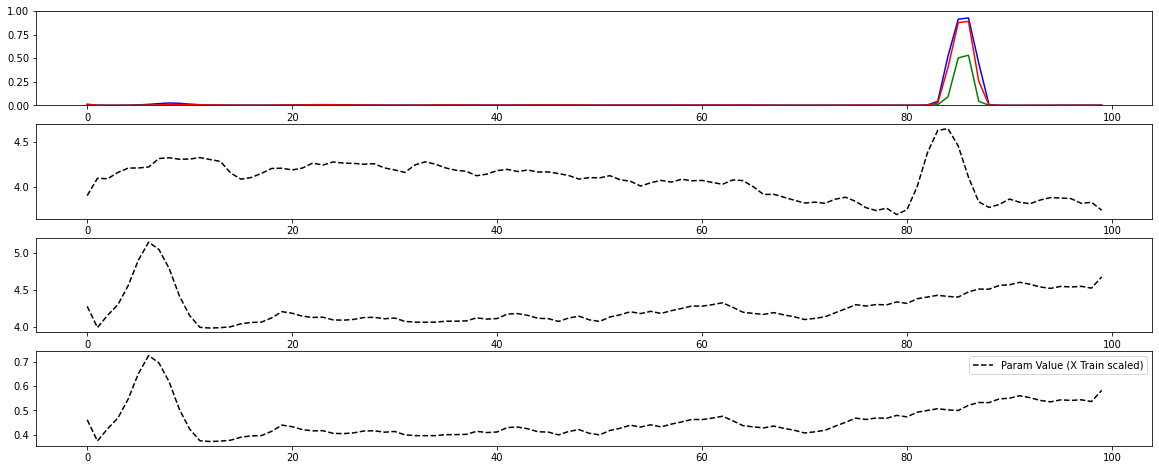

In [38]:
precursor_score = precursor_score_list[0]
fig, ax = plt.subplots(4, figsize=(20, 8))

param_int = 5
ax[0].plot(precursor_score[f'Param{param_int}']['upper'].flatten(), label='pos', c='b')
ax[0].plot(precursor_score[f'Param{param_int}']['lower'].flatten(), label='neg', c='g' )
ax[0].plot(precursor_score['original_score'].flatten(), label='actual', c='r')

ax[1].plot(DF[DF.flight_id == flight_id][f'Param{param_int}'].values, label='Param Value', c='k', ls='dashed')
ax[2].plot(data.trainX[idx, :, data.param_index_dict[f'Param{param_int}']], label='Param Value (X Train)', c='k', ls='dashed')
ax[3].plot(data.scaled_x_train[idx, :, data.param_index_dict[f'Param{param_int}']], label='Param Value (X Train scaled)', c='k', ls='dashed')

ax[0].set_ylim([0, 1])
plt.legend()

In [39]:
feature_scores = compute_features_precursor_scores(precursor_score_list,)

In [40]:
feature_scores

[{'Param1': {'score': [-2.528], 'standard_deviation': [-2]},
  'Param2': {'score': [-0.771], 'standard_deviation': [2]},
  'Param3': {'score': [-0.965], 'standard_deviation': [-2]},
  'Param4': {'score': [-0.446], 'standard_deviation': [-2]},
  'Param5': {'score': [-13.021], 'standard_deviation': [2]},
  'Param6': {'score': [-2.58], 'standard_deviation': [-2]},
  'Param7': {'score': [-1.272], 'standard_deviation': [-2]},
  'Param8': {'score': [-1.557], 'standard_deviation': [-2]},
  'Param9': {'score': [-0.825], 'standard_deviation': [-2]},
  'Param10': {'score': [-1.328], 'standard_deviation': [2]}}]

In [41]:
ranked_features, ranked_scores = rank_features(feature_scores)

In [42]:
ranked_features

[['Param5',
  'Param6',
  'Param1',
  'Param8',
  'Param10',
  'Param7',
  'Param3',
  'Param9',
  'Param2',
  'Param4']]

In [43]:
ranked_scores

[[13.021, 2.58, 2.528, 1.557, 1.328, 1.272, 0.965, 0.825, 0.771, 0.446]]

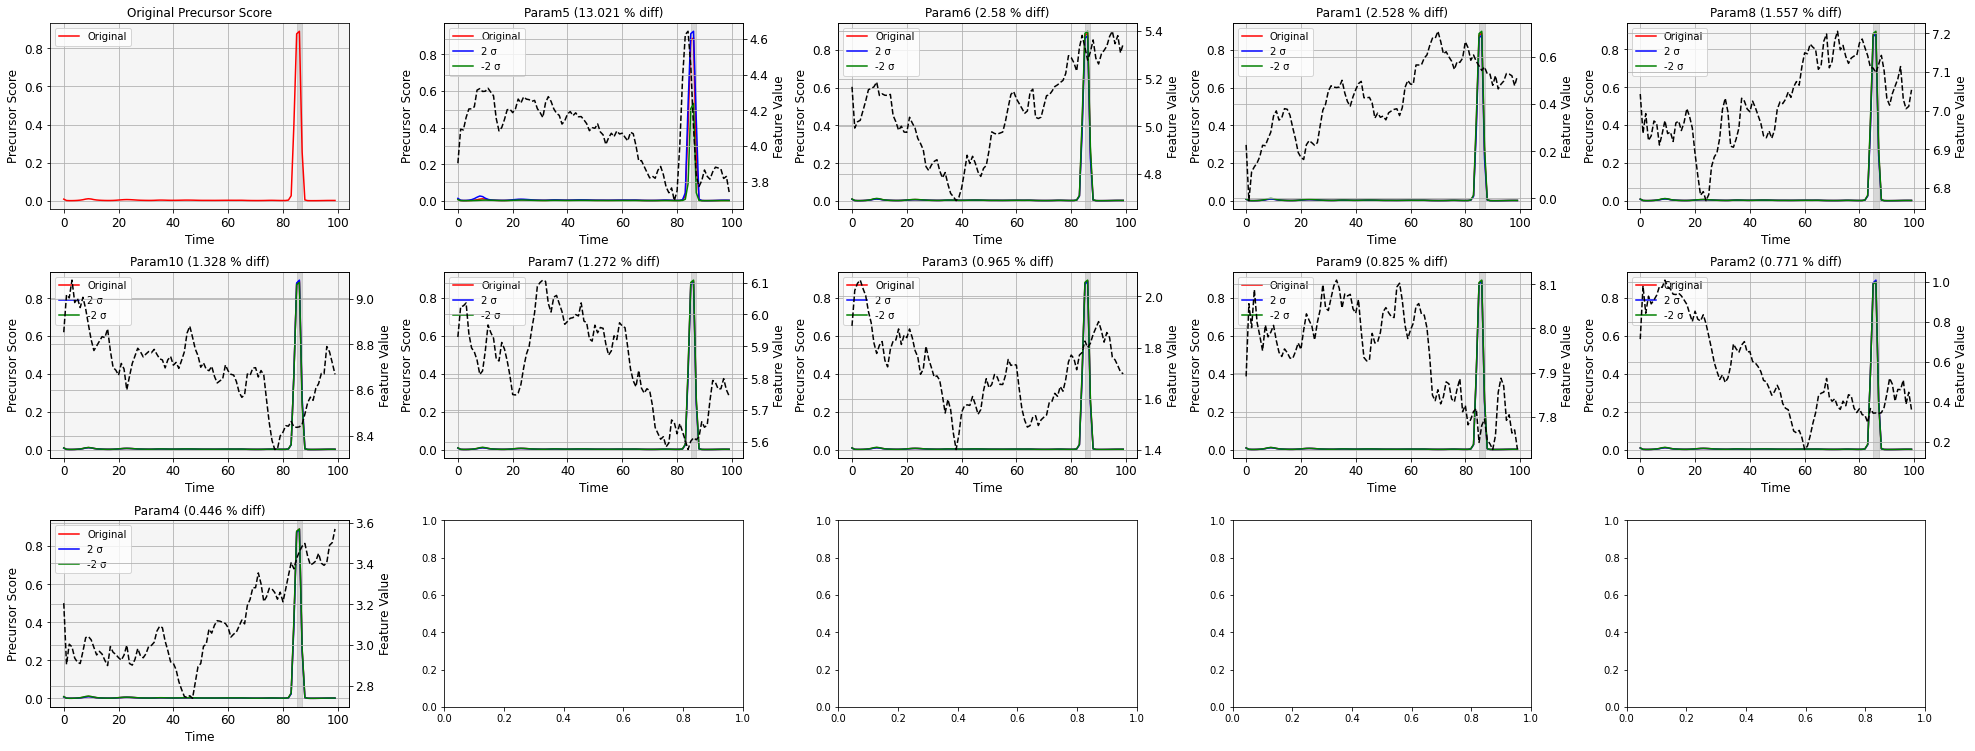

In [44]:
plot_precursor_scores(precursor_score, parameters_list=ranked_features[0],
                      score_list=ranked_scores[0],
                      flight_data=DF[DF.flight_id == flight_id]
                      )

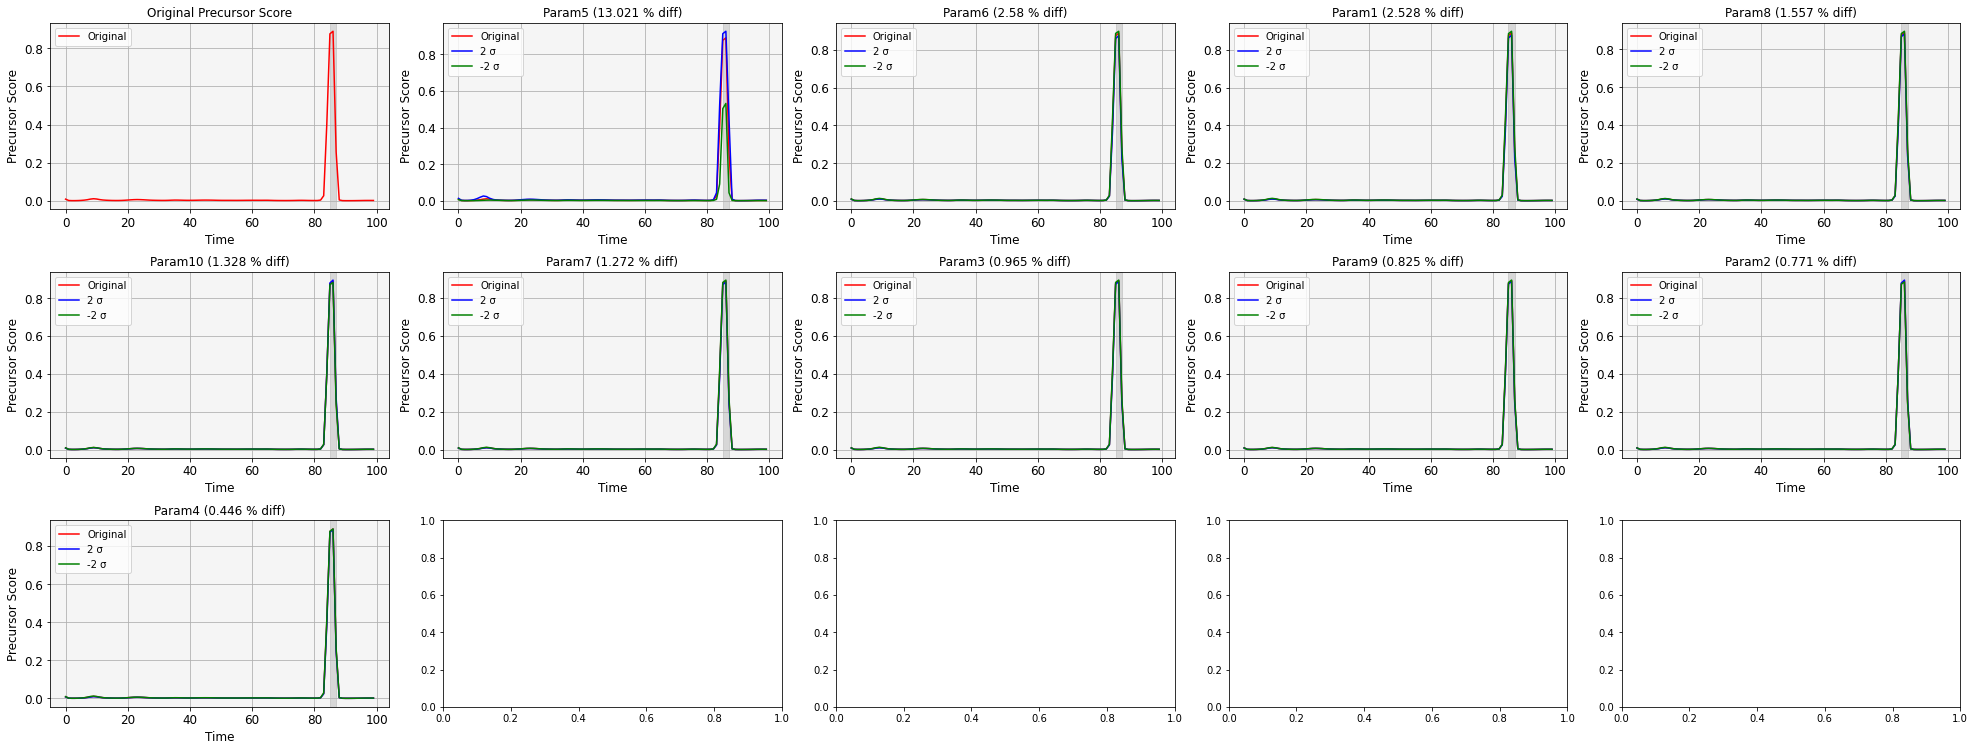

In [45]:
plot_precursor_scores(precursor_score, parameters_list=ranked_features[0],
                      score_list=ranked_scores[0],
                    #   flight_data=DF[DF.flight_id == flight_id]
                      )

As seen above, the top 3 precursors are parameter 5, and 1